In [3]:
!pip install mnist

  Running setup.py bdist_wheel for mnist: started
  Running setup.py bdist_wheel for mnist: finished with status 'done'
  Stored in directory: C:\Users\Alexander\AppData\Local\pip\Cache\wheels\71\37\a9\f62b722aab31f4029866d1ae27486e0932448c8655e7590dc6
Successfully built mnist


In [4]:
import mnist
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


1.4.0
2.1.2


In [5]:
X_train = mnist.train_images()
X_test = mnist.test_images()
y_train = mnist.train_labels()
y_test = mnist.test_labels()

In [6]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# normalize inputs
x_train2 = X_train/255 - 0.5
x_test2 = X_test/255 - 0.5

# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train)
y_test2 = keras.utils.to_categorical(y_test)


In [7]:
# import necessary building blocks
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [8]:
x_train2 = x_train2.reshape((60000,28,28,1))
x_test2 = x_test2.reshape((10000,28,28,1))

In [77]:
data = x_train2
IMG_SHAPE = data.shape[1:]

In [125]:
# !pip install keras

In [126]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L

s = keras.backend.get_session()

In [127]:
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))

generator.add(L.Reshape((8,8,10)))
generator.add(L.Deconv2D(64,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(64,kernel_size=3,activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))

generator.add(L.Conv2D(1,kernel_size=3,activation=None))

In [128]:
IMG_SHAPE

(28, 28, 1)

In [129]:
generator.output_shape[:]

(None, 28, 28, 1)

In [130]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

In [131]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

discriminator.add(L.Conv2D(8, kernel_size=(3, 3)))
discriminator.add(L.LeakyReLU(0.1))
discriminator.add(L.Conv2D(16, kernel_size=(3, 3)))
discriminator.add(L.LeakyReLU(0.1))
discriminator.add(L.MaxPool2D())
discriminator.add(L.Conv2D(32, kernel_size=(3, 3)))
discriminator.add(L.LeakyReLU(0.1))
discriminator.add(L.Conv2D(64, kernel_size=(3, 3)))
discriminator.add(L.LeakyReLU(0.1))
discriminator.add(L.MaxPool2D())

discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))


discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 26, 26, 8)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 24, 24, 16)        1168      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 24, 24, 16)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 10, 10, 32)        4640      
__________

In [132]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE))

logp_real = discriminator(real_data)

generated_data = generator(noise)

logp_gen = discriminator(generated_data)


In [133]:
########################
#discriminator training#
########################

d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

#regularize
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#optimize
disc_optimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)

In [134]:
########################
###generator training###
########################

g_loss = -tf.reduce_mean(logp_gen[:,1])

gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)

    

In [135]:
s.run(tf.global_variables_initializer())

In [136]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE)[:,:,0],cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE)[:,:,0],cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

In [137]:
from IPython import display
from tqdm import tnrange

for epoch in tnrange(4000):
    
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
    
    s.run(gen_optimizer,feed_dict)
    
#     if epoch %2==0:
#         display.clear_output(wait=True)
#         sample_images(2,3,True)
#         sample_probas(1000)
        

In [123]:
images = generator.predict(sample_noise_batch(bsize=1*1))

In [98]:
images.shape

(1, 28, 28, 1)

In [99]:
if np.var(images)!=0:
    images = images.clip(np.min(data),np.max(data))

In [103]:
i=0

In [105]:
IMG_SHAPE

(28, 28, 1)

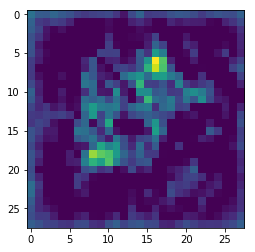

In [121]:
plt.imshow(images[i].reshape(IMG_SHAPE)[:,:,0])

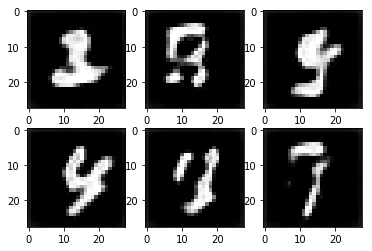

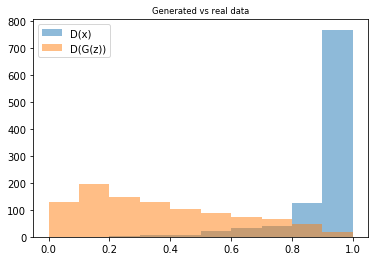

In [138]:
sample_images(2,3,True)
sample_probas(1000)
        

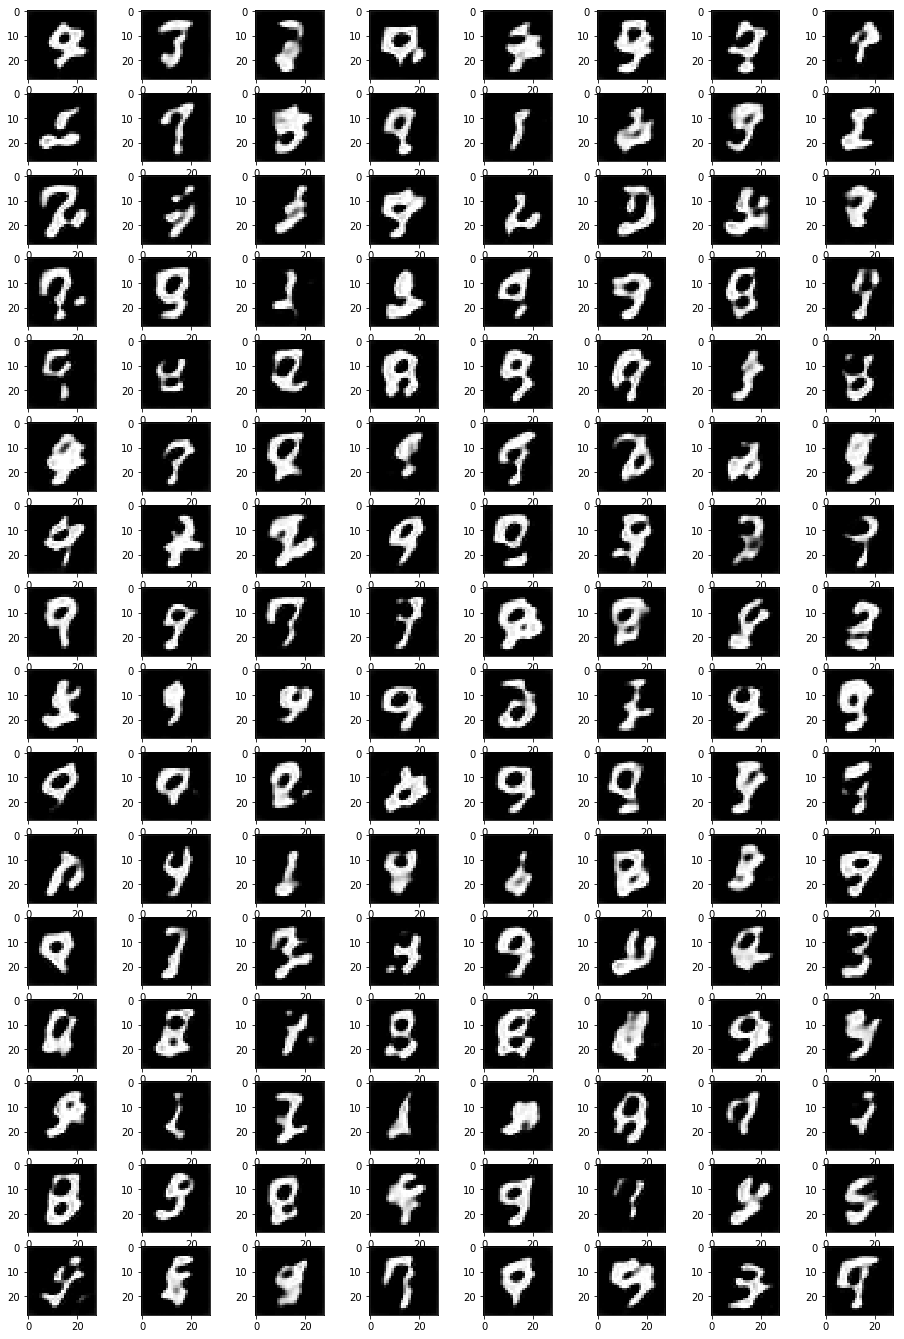

In [139]:
#The network was trained for about 15k iterations. 
#Training for longer yields MUCH better results
plt.figure(figsize=[16,24])
sample_images(16,8)